In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np

from em import em_gaussian_mixture
from old_faithful import get_old_faithful_data

In [2]:
save_path = os.path.expanduser("~/vaes_ptorch/data")
er, waits = get_old_faithful_data(save=True, save_dir=save_path)

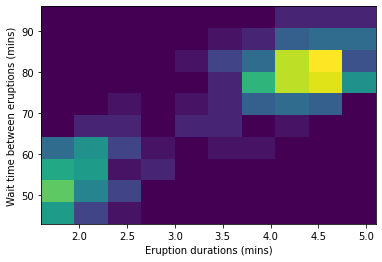

In [3]:
plt.hist2d(er, waits, alpha=1.0)
plt.xlabel("Eruption durations (mins)")
plt.ylabel("Wait time between eruptions (mins)");

In [4]:
data = np.concatenate([er.reshape(-1, 1), waits.reshape(-1, 1)], 1)
theta = em_gaussian_mixture(data, 2, 1000)
theta

Theta(mu=[array([ 4.28966197, 79.96811517]), array([ 2.03638845, 54.47851638])], sigma=[array([[ 0.16996844,  0.94060932],
       [ 0.94060932, 36.04621132]]), array([[ 0.06916767,  0.43516762],
       [ 0.43516762, 33.69728207]])], gamma=array([0.64412714, 0.35587286]))

In [5]:
import torch
import torch.nn as nn
import torch.utils.data as tdata
from vaes_ptorch import VAE, GaussianMLP, TrainArgs, train
from vaes_ptorch.args import DivAnnealing

In [6]:
def scale_data(data):  # of shape n, p
    mean_, std_ = data.mean(0), data.std(0)
    return (data - mean_) / std_, (mean_, std_)


def rescale_data(data, mean_std):
    mean_, std_ = mean_std
    return mean_ + std_ * data

In [7]:
scaled, mean_std = scale_data(data)
dataset = tdata.TensorDataset(torch.from_numpy(scaled).float())
dataloader = tdata.DataLoader(dataset=dataset, batch_size=128, shuffle=True)

In [8]:
latent_dim = 2
data_dim = 2
h_size = 128
h_layers = 10
lr = 1e-3
num_epochs = 500
print_every = 100
start_scale = 0.0
end_scale = 1.0
start_epochs = 100
linear_epochs = 300
info_vae = True

In [12]:
encoder = GaussianMLP(
    in_dim=data_dim, h_dims=[h_size] * h_layers, out_dim=latent_dim
)
decoder = GaussianMLP(
    in_dim=latent_dim, h_dims=[h_size] * h_layers, out_dim=data_dim
)
vae = VAE(encoder=encoder, decoder=decoder)
optimizer = torch.optim.Adam(params=vae.parameters(), lr=lr)
train_args = TrainArgs(
    info_vae=info_vae,
    num_epochs=num_epochs,
    div_annealing=DivAnnealing(
        start_epochs=start_epochs,
        linear_epochs=linear_epochs,
        start_scale=start_scale,
        end_scale=end_scale,
    ),
    print_every=print_every,
    smoothing=0.9,
)

In [13]:
train(data=dataloader, vae=vae, optimizer=optimizer, args=train_args)

Step: 0 | Loss: 0.48517 | Div scale: 0.000
NLL: 0.48517 | MMD-div: 0.00581
Step: 100 | Loss: 0.03553 | Div scale: 0.000
NLL: 0.02925 | MMD-div: 487.70068
Step: 200 | Loss: 0.02461 | Div scale: 0.000
NLL: 0.01134 | MMD-div: 139.63269
Step: 300 | Loss: 0.19344 | Div scale: 0.003
NLL: 0.02549 | MMD-div: 502.28015
Step: 400 | Loss: 0.04764 | Div scale: 0.113
NLL: 0.02858 | MMD-div: 0.13123
Step: 500 | Loss: 0.05651 | Div scale: 0.223
NLL: 0.02767 | MMD-div: 0.26350
Step: 600 | Loss: 0.07985 | Div scale: 0.337
NLL: 0.03029 | MMD-div: 0.08844
Step: 700 | Loss: 0.04174 | Div scale: 0.447
NLL: 0.02183 | MMD-div: 0.00143
Step: 800 | Loss: 0.05917 | Div scale: 0.557
NLL: 0.01771 | MMD-div: 0.22383
Step: 900 | Loss: 0.06771 | Div scale: 0.670
NLL: 0.02533 | MMD-div: 0.00031
Step: 1000 | Loss: 0.08293 | Div scale: 0.780
NLL: 0.02536 | MMD-div: 0.02745
Step: 1100 | Loss: 0.09510 | Div scale: 0.890
NLL: 0.03364 | MMD-div: 0.04303
Step: 1200 | Loss: 0.06031 | Div scale: 1.000
NLL: 0.01929 | MMD-div: 

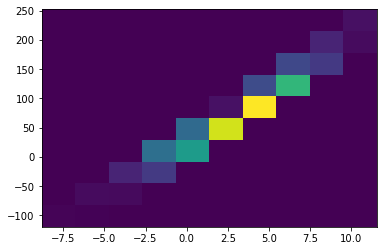

In [18]:
# test = torch.from_numpy(scaled).float()

num_samples = 1000
# TODO - better this
vae.eval()
with torch.no_grad():
    z_samples = torch.randn((num_samples, latent_dim))
    # z_samples = out.mu_z + torch.randn_like(out.mu_z) * torch.sqrt(out.sig_z)
    mu_x, sig_x = vae.decoder(z_samples)
    x_samples = mu_x + torch.randn_like(mu_x) * torch.sqrt(sig_x)
    # z_2d = z_samples.detach().numpy()
    x_2d = rescale_data(x_samples.detach().numpy(), mean_std)
    # plt.hist2d(z_2d[:, 0], z_2d[:, 1])
    plt.hist2d(x_2d[:, 0], x_2d[:, 1])

In [ ]:
# mu = torch.tensor([[1.0, -1.0,]])
# sig = torch.tensor([[2.0, 2.0]])
# t1 = np.linspace(0.1, 1.0)
# X, Y = np.meshgrid(t1, t1)
# Z = np.zeros_like(X)
# for i in range(t1.shape[0]):
#     for j in range(t1.shape[0]):
#         Z[i, j] += gaussian_kl(
#             left_mu=X[i, j] * mu,
#             left_sig=Y[i, j] * sig,
#             right_mu=torch.zeros_like(mu),
#             right_sig=torch.ones_like(sig),
#         )
#         Z[i, j] += nn.GaussianNLLLoss()(mu, X[i, j] * mu, Y[i, j] * sig)

# plt.contour(X, Y, Z, 20, cmap="RdGy")
# plt.colorbar()